In [1]:
import os
import time
import matplotlib.pyplot as plt

from monai.config import print_config
from monai.data import DataLoader, decollate_batch, Dataset, ArrayDataset
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from sklearn.model_selection import train_test_split
from monai.transforms import (
    Activations,

    AsDiscrete,
    AsDiscreted,
    Compose,
 
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    CropForegroundd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
    SpatialPadd,
    SpatialCropd,
    ScaleIntensityd,
    ShiftIntensityd,
    ResizeD,
    AdjustContrastd,
    RandGaussianSharpend,
    RandHistogramShiftd,
    RandStdShiftIntensityd,
    RandAdjustContrastd,
    ToDeviced
    
)
from monai.utils import set_determinism
import numpy as np
import torch

import matplotlib.colors as mcolors
import torch
import torch.nn as nn
import torch.nn.functional as F
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.transforms import Activations, AsDiscrete
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset
from monai.utils import set_determinism
import os
import glob
import nibabel as nib
import numpy as np

import torch
from monai.transforms import Transform,ThresholdIntensity, RandCropByPosNegLabeld,Compose, LoadImaged, EnsureChannelFirstd, EnsureTyped, NormalizeIntensityd, ResizeD,RandAffined, RandFlip
from monai.transforms import (
    AsDiscreted,
    Compose,

    LoadImaged,

)
from monai.data.utils import pad_list_data_collate, decollate_batch
import os
from monai.transforms import Compose, LoadImaged, AddChanneld, ScaleIntensityRanged, ToTensord





In [2]:
data_dir =  "/home/Task07_Pancreas/"

In [3]:
train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
val_files, train_files = data_dicts[:20], data_dicts[20:]


In [4]:
class GettheDesiredLabels(Transform):
    def __call__(self, data):
        label = data["label"]
        # Keep only the second and third channels from the label
        single_label = label[1:3]

        data["label"] = single_label
        return data


In [7]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ToDeviced(keys=["image", "label"], device="cuda:0"),
        AsDiscreted(keys='label', to_onehot=3),
        GettheDesiredLabels(),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        
        ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label

        ToTensord(keys=["image", "label"]),
        # RandCropByPosNegLabeld(
        #     keys=["image", "label"],
        #     label_key="label",
        #     spatial_size=(224, 224, 144),
        #     pos=3,
        #     neg=1,
        #     num_samples=2,
        #     image_key="image"
        # )
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        AsDiscreted(keys='label', to_onehot=3),
        GettheDesiredLabels(),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1, 1, 1), mode=("bilinear", "nearest")),
        ResizeD(keys=["image", "label"], spatial_size=[224, 224, 144], mode=("trilinear", "nearest")),  # Resize image and label
        ToTensord(keys=["image", "label"]),
    ]
)

In [8]:
train_dataset = CacheDataset(data=train_files, transform=train_transforms)
val_dataset = CacheDataset(data=val_files, transform=val_transforms)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=1, collate_fn=pad_list_data_collate)
val_loader = DataLoader(val_dataset, batch_size=1, collate_fn=pad_list_data_collate)

Loading dataset:  84%|████████▍ | 219/261 [03:09<00:36,  1.16it/s]


RuntimeError: applying transform <monai.transforms.spatial.dictionary.Spacingd object at 0x7f7ed6ce21f0>

In [ ]:
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 261
Number of validation samples: 20


In [22]:
    
sample_index = 0  # Specify the index of the sample to check
sample = train_dataset[sample_index]
binarized_label = sample[0]['label']
unique_values = torch.unique(binarized_label)
count = len(unique_values)
print(f"Number of unique values: {count}")

KeyError: 0

In [9]:
# Get the first sample in the dataset
first_sample = train_dataset[0]


image_shape = first_sample['image'].shape
label_shape = first_sample['label'].shape

print(f"Image shape: {image_shape}")
print(f"Label shape: {label_shape}")


Image shape: torch.Size([1, 224, 224, 144])
Label shape: torch.Size([2, 224, 224, 144])


144


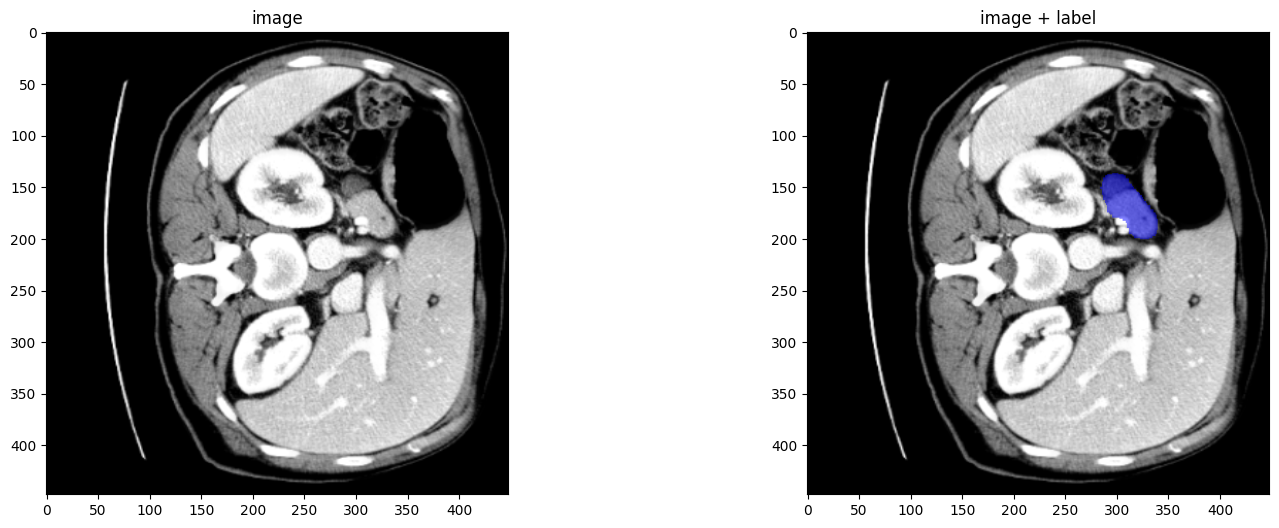

144


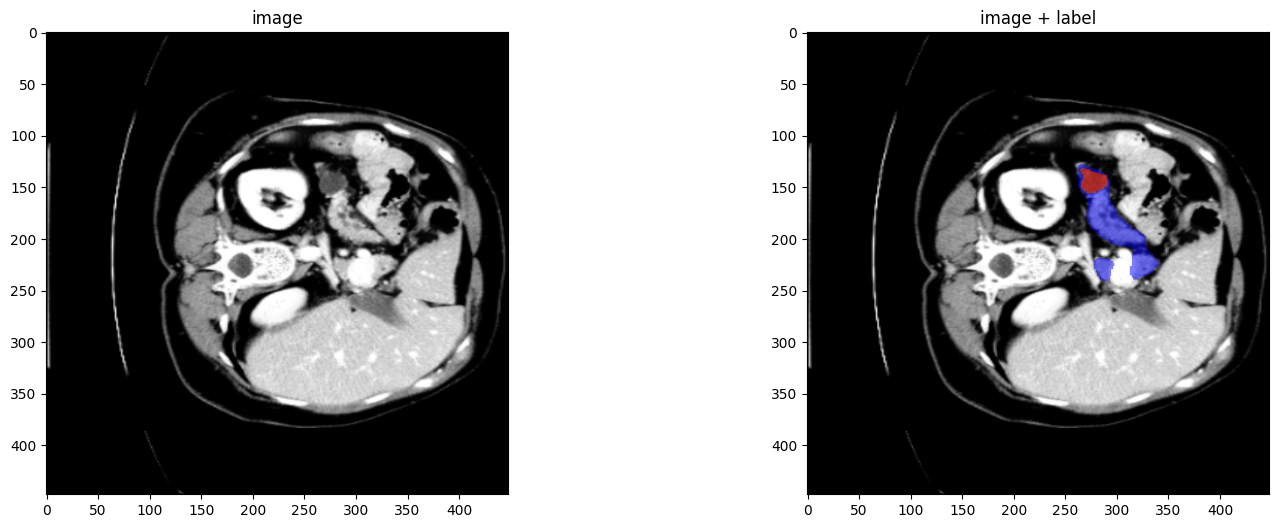

In [23]:
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha',colors)
for i in range(1,3):                                               
    val_data_example=train_dataset[i]
    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example['image'].shape[3] // 2  # adjust to the depth dimension
    print(slice_idx)
    # Get image and labels
    image = val_data_example['image'][0, :, :, slice_idx].detach().cpu()
    label3 = val_data_example['label'][1, :, :, slice_idx].detach().cpu()
    label2 = val_data_example['label'][0, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels
    # We're using different colors and transparency (alpha) for each label
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency
    plt.imshow(label3, cmap=red_cmap, alpha=0.5)  # Change 'jet' to any colormap you prefer

    # plt.axis('off')  # To not show axis
    plt.show()


72


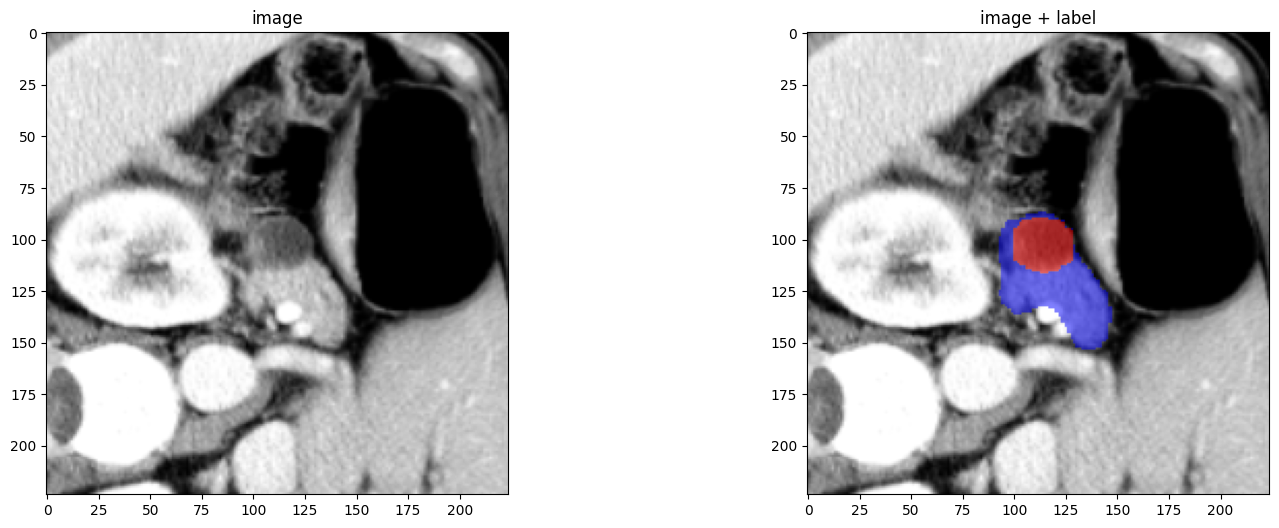

72


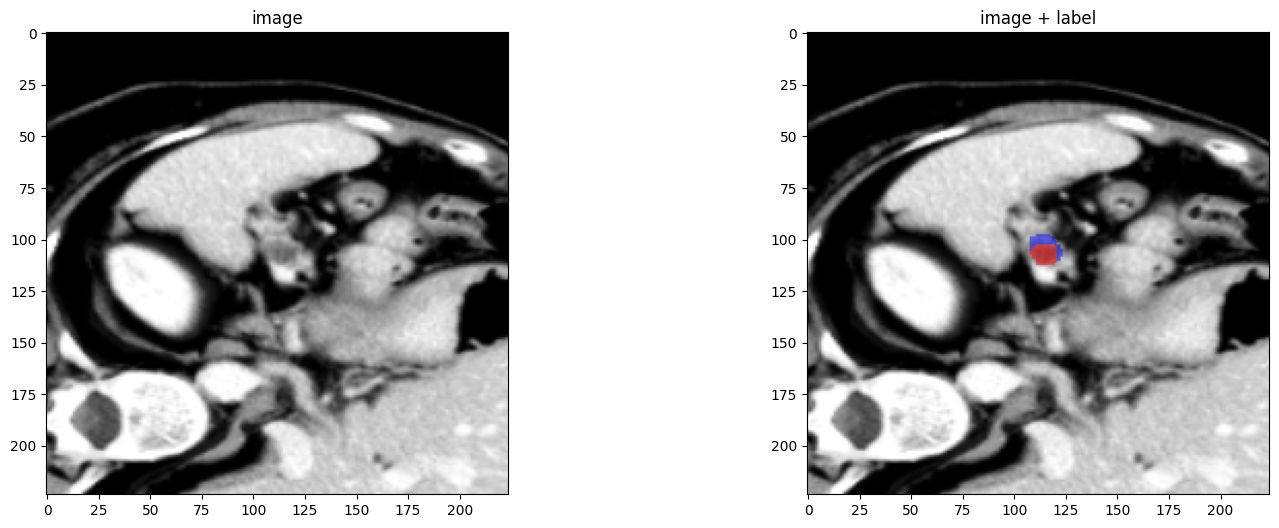

In [18]:
colors = [(0, 0, 1, i) for i in np.linspace(0, 1, 100)]
blue_cmap = mcolors.LinearSegmentedColormap.from_list('blue_alpha', colors)

colors = [(1, 0, 0, i) for i in np.linspace(0, 1, 100)]
red_cmap = mcolors.LinearSegmentedColormap.from_list('red_alpha',colors)
for i in range(1,3):                                               
    val_data_example=train_dataset[i]
    # Select a slice to visualize (e.g., the middle slice)
    slice_idx = val_data_example[0]['image'].shape[3] // 2  # adjust to the depth dimension
    print(slice_idx)
    # Get image and labels
    image = val_data_example[0]['image'][0, :, :, slice_idx].detach().cpu()
    label3 = val_data_example[0]['label'][1, :, :, slice_idx].detach().cpu()
    label2 = val_data_example[0]['label'][0, :, :, slice_idx].detach().cpu()

    # Create a figure
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 2, 1)
    plt.title("image")
    plt.imshow(image, cmap='gray')

    # Overlay the labels
    # We're using different colors and transparency (alpha) for each label
    plt.subplot(1, 2, 2)
    plt.title("image + label")
    plt.imshow(image, cmap='gray')
    plt.imshow(label2, cmap=blue_cmap, alpha=0.5)  # Use alpha for transparency
    plt.imshow(label3, cmap=red_cmap, alpha=0.5)  # Change 'jet' to any colormap you prefer

    # plt.axis('off')  # To not show axis
    plt.show()


In [24]:

# Define your UNet model as a function
def unet(in_channels, out_channels):
    model = SegResNet(
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        in_channels=in_channels,
        out_channels=out_channels,
        dropout_prob=0.2,
    )
    return model


In [25]:
device = torch.device('cuda')
num_gpus = torch.cuda.device_count()

device_ids = [0]  # Specify the GPU device IDs to be used
print("Using", num_gpus, "GPUs!")


Using 3 GPUs!


In [26]:

# Define your UNet model
in_channels = 1
out_channels = 2
model = unet(in_channels, out_channels)
model = model.to(device)
if torch.cuda.device_count() > 1:
    print("Using ", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, device_ids=device_ids)


# Rest of the code
max_epochs = 100
val_interval = 1
VAL_AMP = True


loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(224, 224, 144),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


scaler = torch.cuda.amp.GradScaler()
torch.backends.cudnn.benchmark = True


Using  3 GPUs!


In [27]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_class1 = []
metric_values_class2 = []
model_dir =  "/home/model_codes/"
max_epochs = 100

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
 
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_dataset) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_class1 = metric_batch[0].item()
            metric_values_class1.append(metric_class1)
            metric_class2 = metric_batch[1].item()
            metric_values_class2.append(metric_class2)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(model, os.path.join(model_dir, "best_metric_model_bg_v4_mon1.pth"))
                print("Saved new best metric model")
                
     

            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" class1: {metric_class1:.4f} class2: {metric_class2:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start




----------
epoch 1/100


OutOfMemoryError: CUDA out of memory. Tried to allocate 882.00 MiB (GPU 0; 39.44 GiB total capacity; 25.89 GiB already allocated; 79.88 MiB free; 26.31 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
model_dir =  "/home/model_codes/"
torch.save(
    model.state_dict(),
    os.path.join(model_dir, "best_metric_model_bg_v4.pth"),
)
print("saved new best metric model")

In [ ]:
import matplotlib.pyplot as plt

# Plot epochs vs train loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_epochs + 1), epoch_loss_values, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs. Train Loss')
plt.legend()
plt.show()

# Plot epochs vs mean dice score
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values, label='Mean Dice Score')
plt.xlabel('Epoch')
plt.ylabel('Mean Dice Score')
plt.title('Epochs vs. Mean Dice Score')
plt.legend()
plt.show()

# Plot epochs vs class 1, 2, and 3 dice scores
plt.figure(figsize=(10, 6))
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class1, label='Pancreas')
plt.plot(range(val_interval, max_epochs + 1, val_interval), metric_values_class2, label='Tumor')

plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Epochs vs. Dice Score (Pancreas and Tumor)')
plt.legend()
plt.show()
